# HannesImitationDataset
The HannesImitationDataset comprises 3 collections, each with 150 demonstrations.

In this notebook we can explore the demonstrations.

In [2]:
import sys
sys.path.append('../../hannes-imitation/')

from hannes_imitation.common.data_utils import filter_demonstrations, index_alignment, resize_image, store_merged_data_to_zarr
from hannes_imitation.common.config import load_configuration
import os
import zarr
import numpy as np
from tqdm import tqdm
import cv2
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation

# load configuration file
config_path = '../../hannes-imitation/hannes_imitation/config/data/config_hand_wrist_IROS2025.yaml' 
config = load_configuration(config_path)

# extract configuration parameters
source_dir = config['directory']['source']

In [3]:
# let's print the names of the source directories containing the collections
for dir_name in source_dir:
    print(dir_name)

/home/calessi-iit.local/Projects/hannes-imitation/data/training/HannesImitation/1_grasp-ycb-table/
/home/calessi-iit.local/Projects/hannes-imitation/data/training/HannesImitation/4_grasp-ycb-shelf/
/home/calessi-iit.local/Projects/hannes-imitation/data/training/HannesImitation/7_handover-15ycb-clutter/


In [4]:
# each directory contains several demonstrations. Each demonstration is saved in a separate zarr file.
# let's put the list of demonstration names

hi_data_paths = {
    'table-grasp': [],
    'shelf-grasp': [],
    'human-to-hannes handover': []}

for key, dir_name in zip(hi_data_paths.keys(), source_dir):
    demonstration_names = os.listdir(dir_name)
    
    for demo_name in demonstration_names:
        demo_path = os.path.join(dir_name, demo_name)
        hi_data_paths[key].append(demo_path) 

Let's see the structure of one demonstration inside the `Table Grasp` collection

In [5]:
zarr_path = hi_data_paths['table-grasp'][0]

store = zarr.open(zarr_path)
store.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='emg (153, 6) int64', …

As you can see, there are many fields comprising the Hannes state. 

For the HannesImitationDataset we are only interested in a few major fields: 

- `time` contains the time stamps of each hannes state, that is the time stamp associated to each of the fields described below.
- `references` contains the reference commands or actions provided to Hannes. In particular we use `hand` to open and close the fingers, `wrist_FE` to flex and extend the wrist, and `wrist_PS` to pronate and supinate the wrist.
- `joints` contains proprioceptive data of the Hannes encoders. In particular we use `hand` and `wrist_FE`.
- `in-hand_camera_0` contains the frames from the camera embedded in the Hannes palm associated time stamps, which are different but similar from the time stamps of the hannes states. The frames are in the `rbg` field and the frame time stamps in `time`.

Let's extract these fields:

In [6]:
ref_move_hand = store['references']['hand'][:]
ref_move_wrist_FE = store['references']['wrist_FE'][:]
ref_move_wrist_PS = store['references']['wrist_PS'][:]
mes_hand = store['joints']['hand']['position'][:]
mes_wrist_FE = store['joints']['wrist_FE']['position'][:]
camera = store['in-hand_camera_0']['rgb'][:]
hand_times = store['time'][:]
camera_times = store['in-hand_camera_0']['time'][:]

Each demonstration has also a few metadata

In [7]:
store.attrs['label']

{'clutter': 'no',
 'object': 'box of gelatine',
 'scenario': 'table',
 'task': 'grasp'}

## Statistics
Let's check some statistics. 

For convenience we create a Pandas DataFrame so that we can apply some queries.

In [15]:
df = {'task': [], 'clutter': [], 'scenario': [], 'object': [], 'duration': [], 'n_images': [], 'n_states': [], 'demo_path': []}

# iterate over collections
for key, demo_paths in hi_data_paths.items():
    # iterate over demo paths
    for demo_path in demo_paths:
        # load demonstration store
        store = zarr.open(demo_path)

        # extract metadata and high-level statistics
        attributes = store.attrs['label']
        hand_times = store['time'][:]
        demo_duration = hand_times[-1] - hand_times[0]
        n_images = camera = store['in-hand_camera_0']['rgb'][:].shape[0]

        # append values to each column
        df['task'].append(attributes['task'])
        df['object'].append(attributes['object'])
        df['scenario'].append(attributes['scenario'])
        df['clutter'].append(attributes['clutter'])
        df['duration'].append(demo_duration)
        df['n_images'].append(n_images)
        df['n_states'].append(len(hand_times))
        df['demo_path'].append(demo_path)

# construct the dataframe from the dictionary
df = pd.DataFrame.from_dict(df)

Let's see for each collection
- total duration of the demonstrations (in seconds)
- total number of images
- total number of hand states

In [16]:
df.groupby(['scenario', 'task'])[['duration', 'n_images', 'n_states']].sum().round()

duration  n_images  n_states
scenario task                                  
-        handover     795.0     14703     34152
shelf    grasp       1160.0     21963     49758
table    grasp       1016.0     19111     43603

and also report the aggregate for the entire dataset.

In [17]:
print("Total duration: %.1f minutes" % (df['duration'].sum() / 60))
print("Total images: %d" % df['n_images'].sum())
print("Total states: %d" % df['n_states'].sum())

Total duration: 49.5 minutes
Total images: 55777
Total states: 127513


We might be interested in knowing the averages

In [18]:
df.groupby(['scenario', 'task'])[['duration', 'n_images', 'n_states']].mean().round()

duration  n_images  n_states
scenario task                                  
-        handover       5.0      98.0     228.0
shelf    grasp          8.0     146.0     332.0
table    grasp          7.0     127.0     291.0

In [20]:
df.groupby(['scenario', 'task', 'clutter', 'object'])[['duration', 'n_images', 'n_states']].sum().round(1)

duration  n_images  \
scenario task     clutter object                                             
-        handover yes     apple                             42.1       762   
                          bleach cleanser                   53.8       995   
                          box of chocolate pudding          50.0       920   
                          box of gelatine                   52.5       969   
                          box of sugar                      50.7       934   
                          enamel-coated metal bowl          53.3       986   
                          flat-head screwdriver             55.2      1025   
                          foam brick                        53.5       988   
                          medium stacking cup orange        55.1      1021   
                          orange                            48.8       898   
                          pear                              55.8      1037   
                          pitcher                           67.9      1276   
                          power drill                       59.5      1108   
                          small stacking cup blue           50.8       936   
                          tennis ball                       46.4       848   
shelf    grasp    no      apple                             79.0      1495   
                          bleach cleanser                   69.8      1316   
                          box of chocolate pudding          67.9      1279   
                          box of gelatine                   69.3      1305   
                          box of sugar                      75.7      1430   
                          enamel-coated metal bowl          77.9      1477   
                          flat-head screwdriver            100.2      1918   
                          foam brick                        66.4      1246   
                          medium stacking cup orange       104.0      1996   
                          orange                            66.2      1245   
                          pear                              70.3      1326   
                          pitcher                           71.7      1351   
                          power drill                      109.6      2107   
                          small stacking cup lightblue      76.1      1443   
                          tennis ball                       55.5      1029   
table    grasp    no      apple                             61.0      1140   
                          bleach cleanser                  111.6      2147   
                          box of chocolate pudding          66.0      1237   
                          box of gelatine                   52.9       980   
                          box of sugar                      61.5      1149   
                          enamel-coated metal bowl          64.6      1214   
                          flat-head screwdriver             68.2      1284   
                          foam brick                        76.8      1453   
                          medium stacking cup orange        53.9       997   
                          orange                            66.4      1249   
                          pear                              46.4       849   
                          pitcher                           78.6      1490   
                          power drill                       75.4      1428   
                          small stacking cup ligthblue      74.4      1402   
                          tennis ball                       58.5      1092   

                                                        n_states  
scenario task     clutter object                                  
-        handover yes     apple                             1811  
                          bleach cleanser                   2304  
                          box of chocolate pudding          2149  
                          box of gelatine             

## Visualize demonstrations

In [55]:
df_table = df[df.scenario == 'table']
df_shelf = df[df.scenario == 'shelf']
df_human_to_hannes = df[df.scenario == '-']

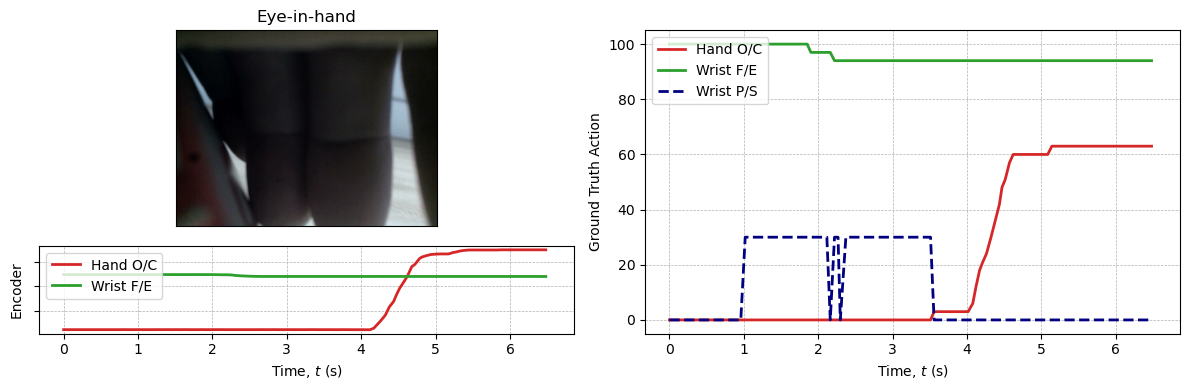

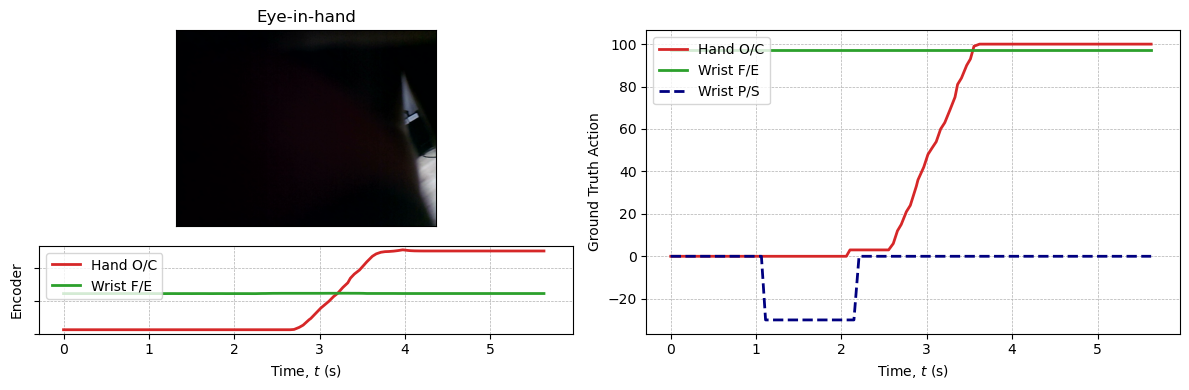

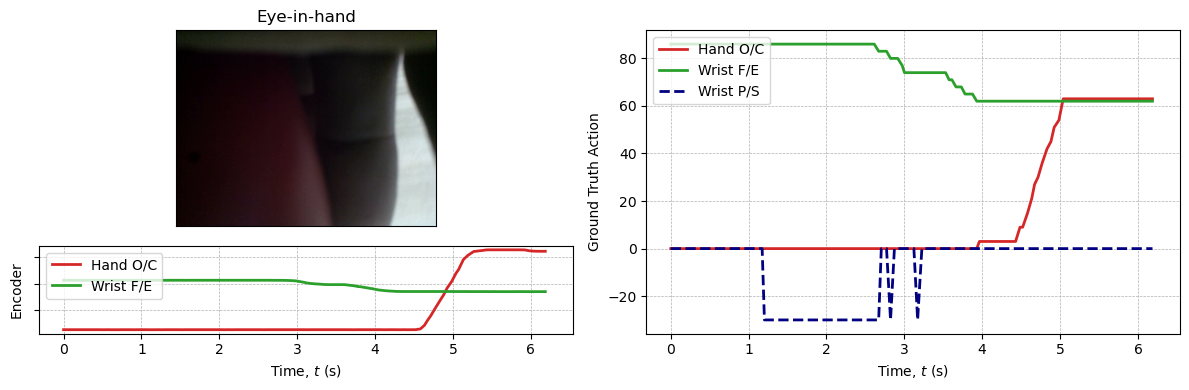

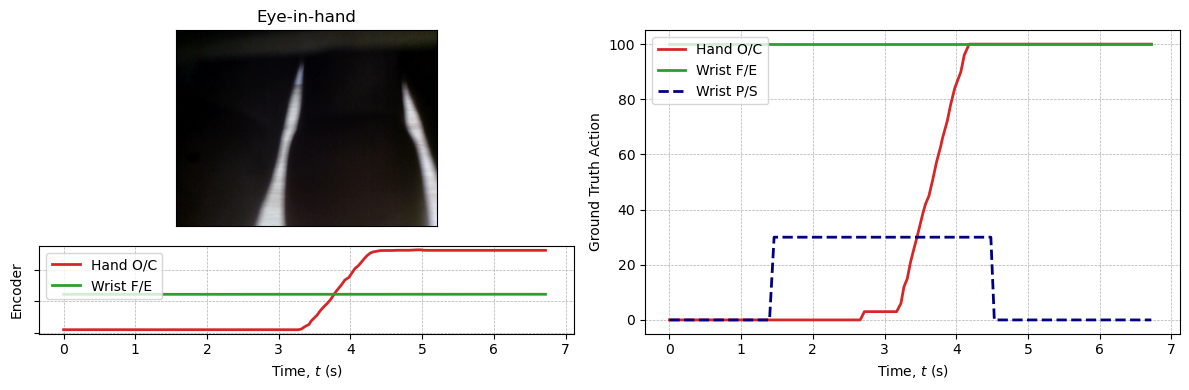

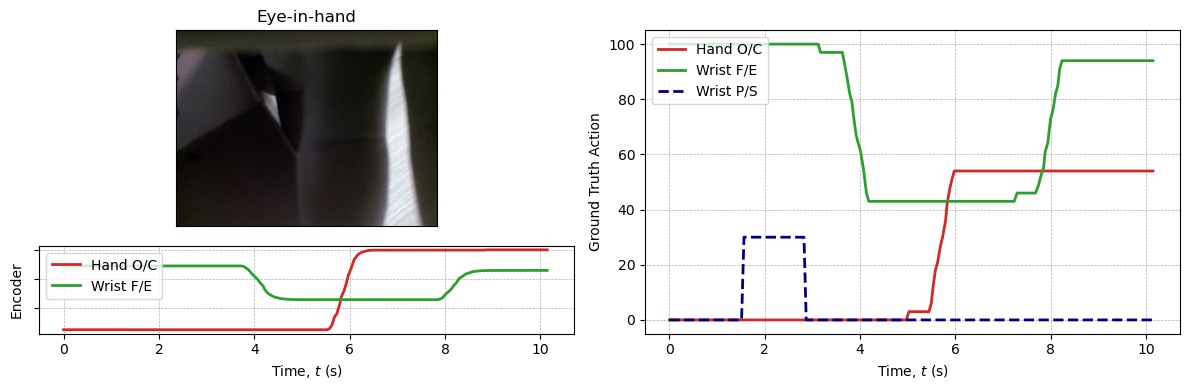

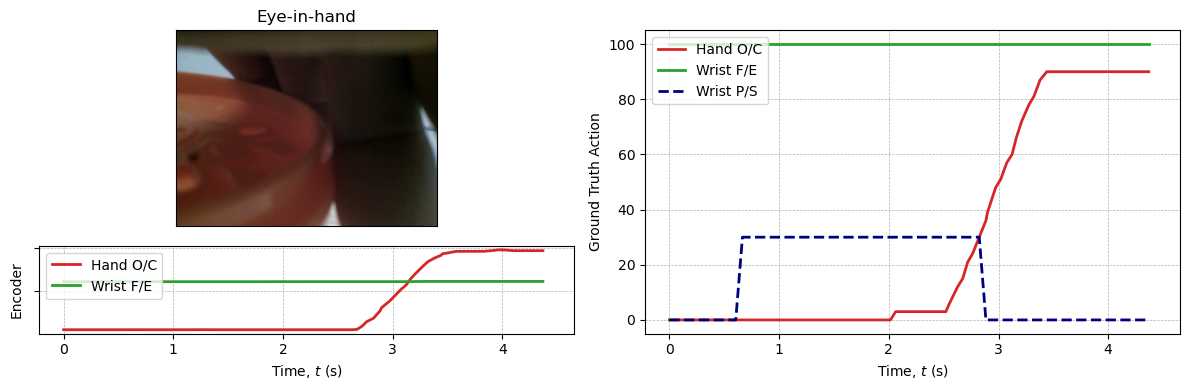

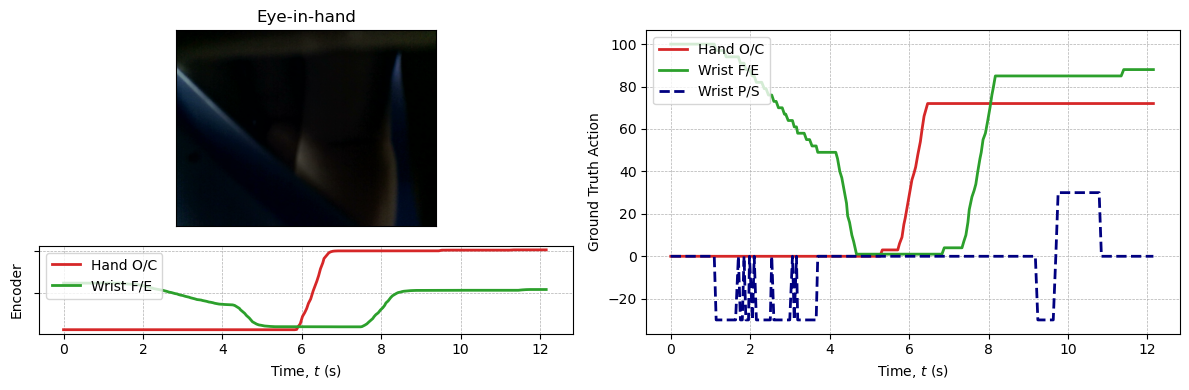

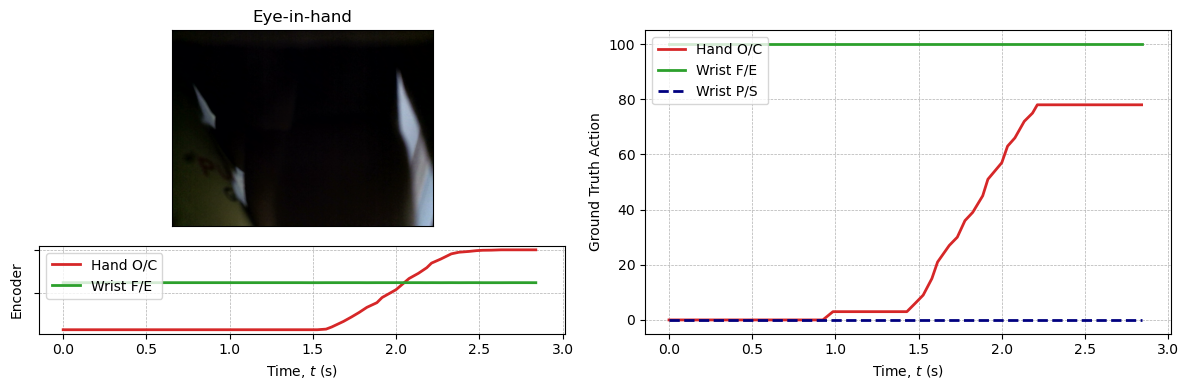

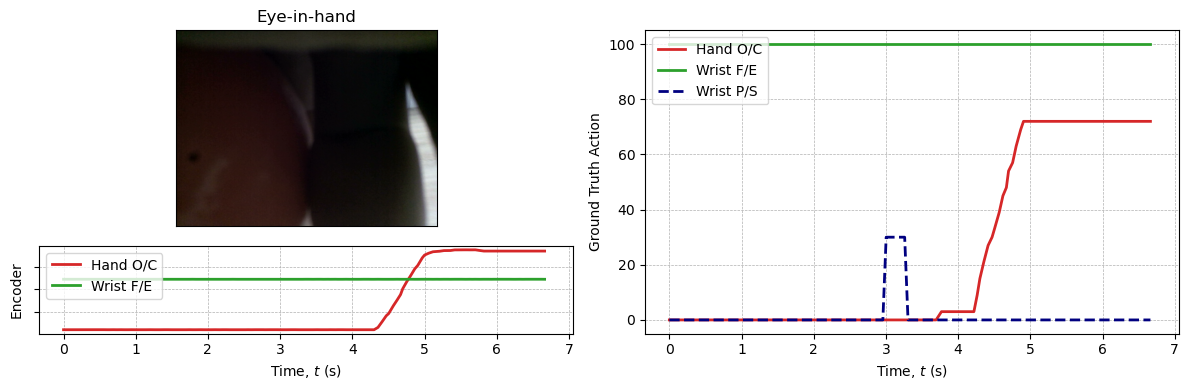

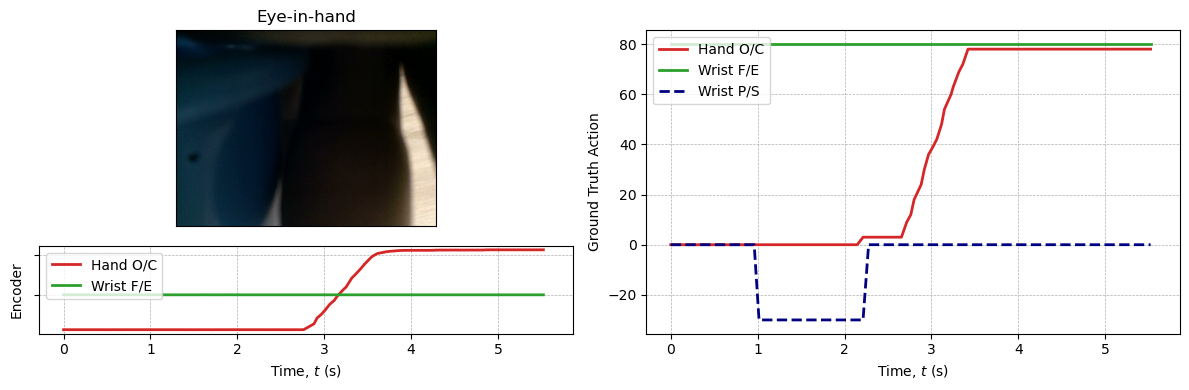

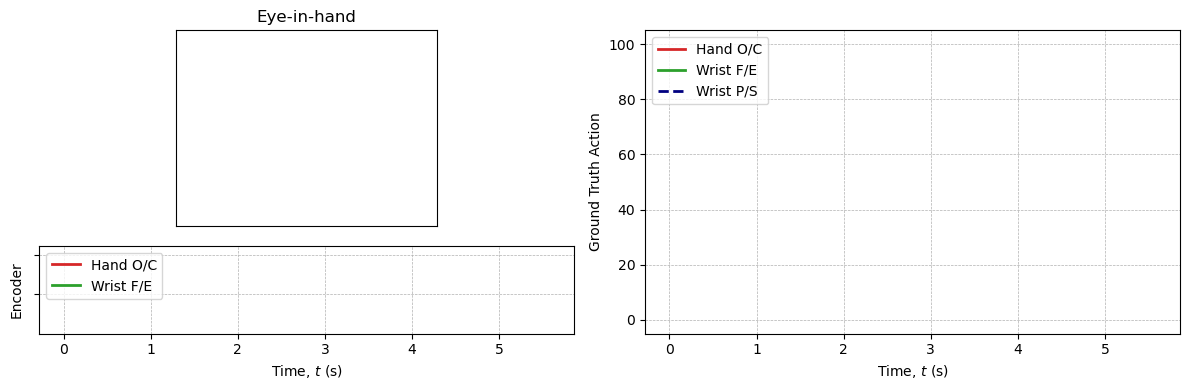

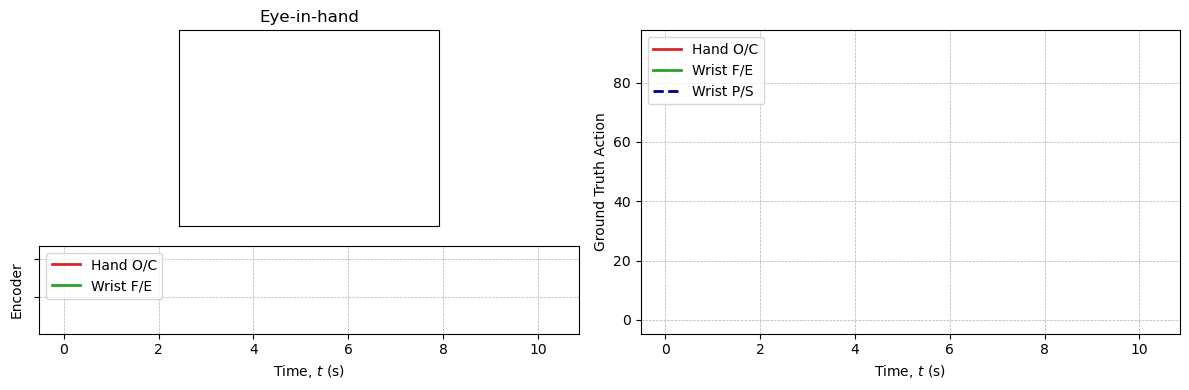

In [ ]:
table_grasp_sampled_demo_paths = []

for object_name in df_table.object.unique():
    object_demo_paths = df_table[df_table.object == object_name]['demo_path'].to_list() # extract all demo paths for that scenario/object
    random_index = np.random.randint(len(object_demo_paths))
    table_grasp_sampled_demo_paths.append(object_demo_paths[random_index]) 

for i, demo_path in enumerate(table_grasp_sampled_demo_paths):
    store = zarr.open(demo_path)
    
    video_path = '/home/calessi-iit.local/Projects/hannes-imitation/figures/data_exploration/1_table_grasp/' + str(i+1) + '.mp4'

    make_video_demonstration_from_store(store, video_path)

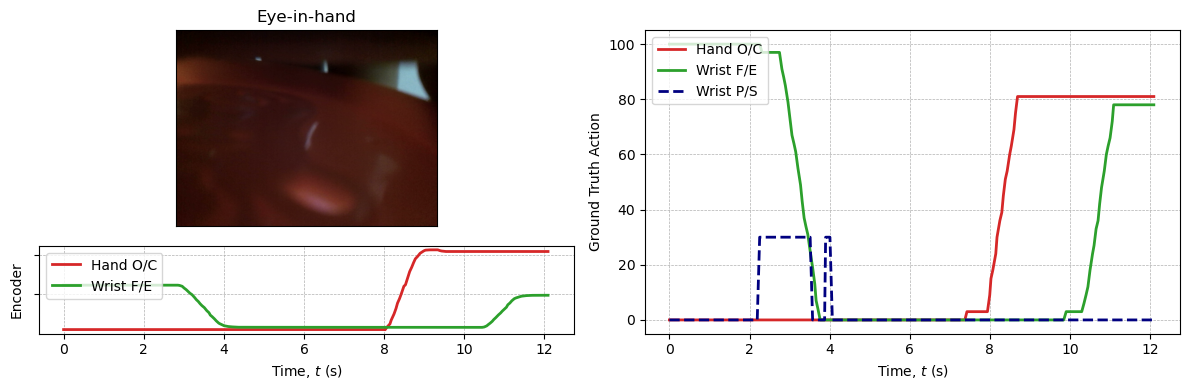

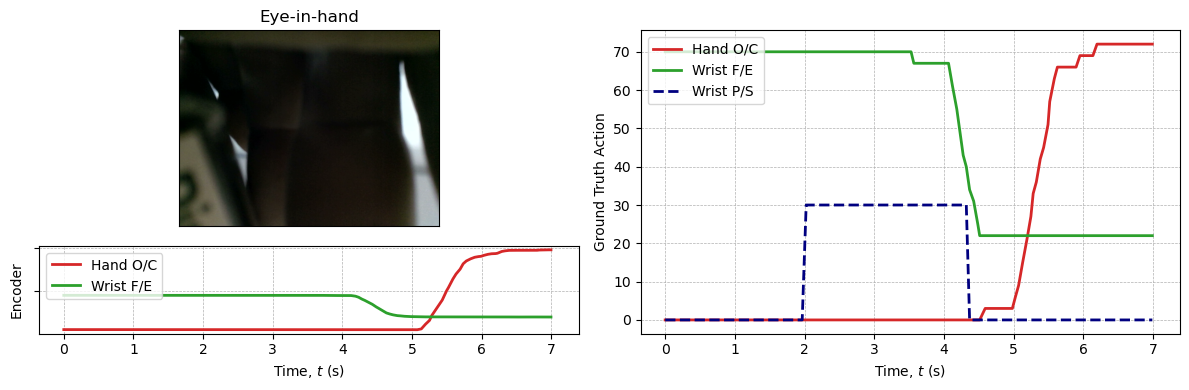

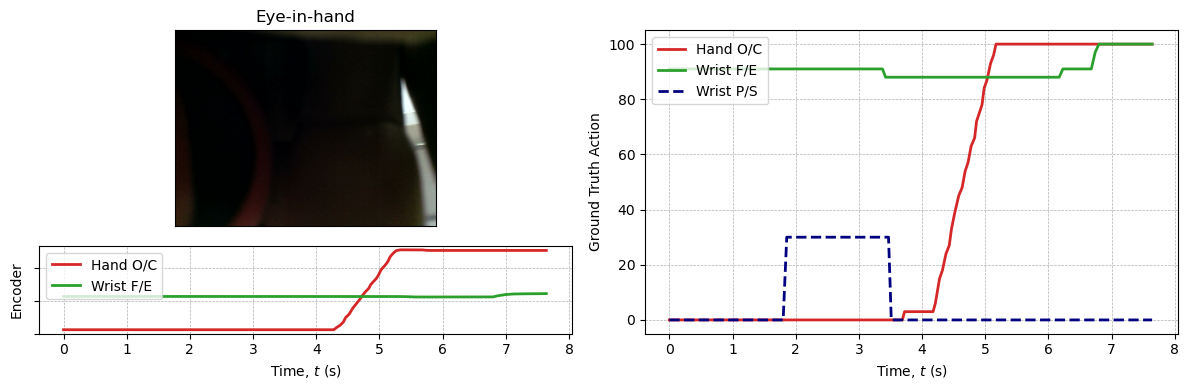

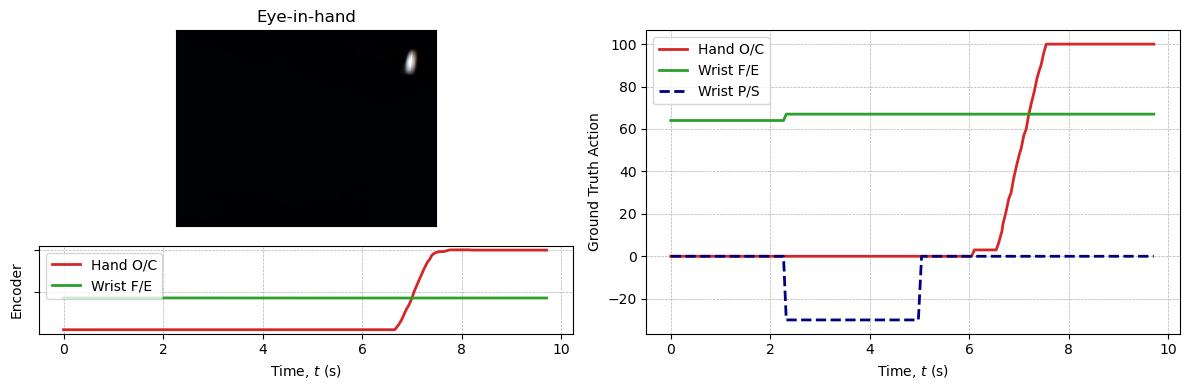

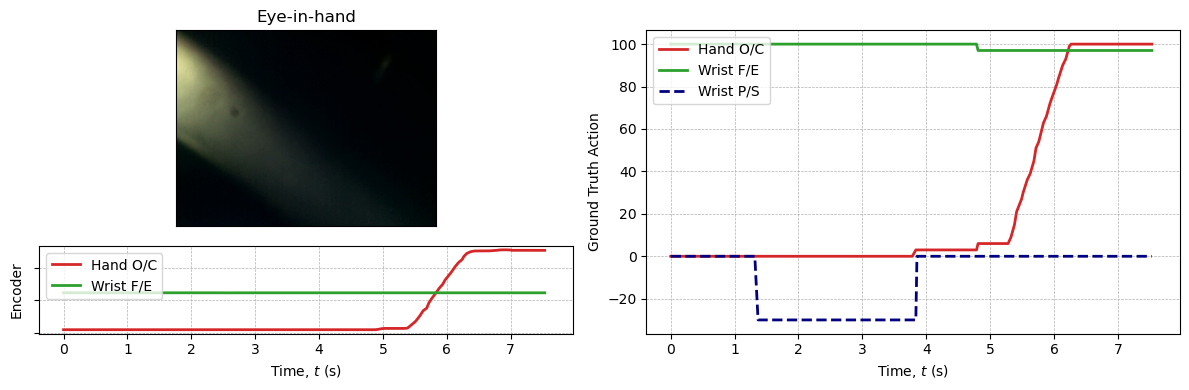

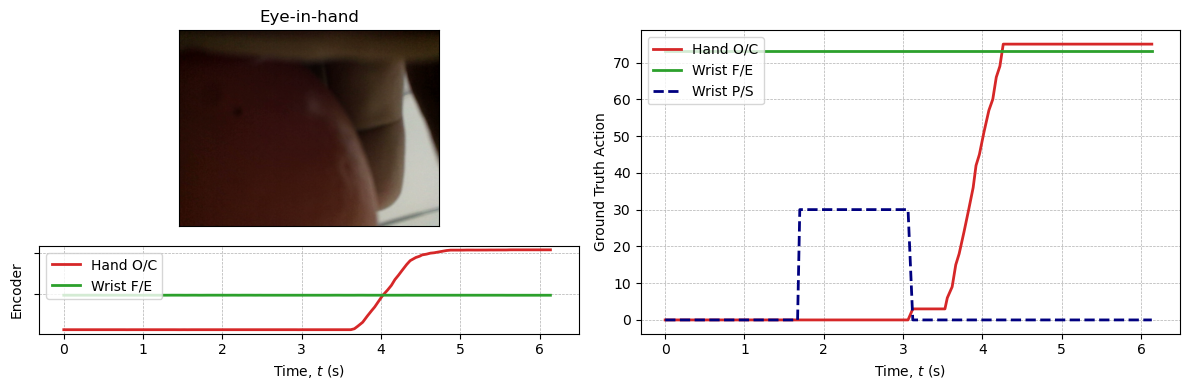

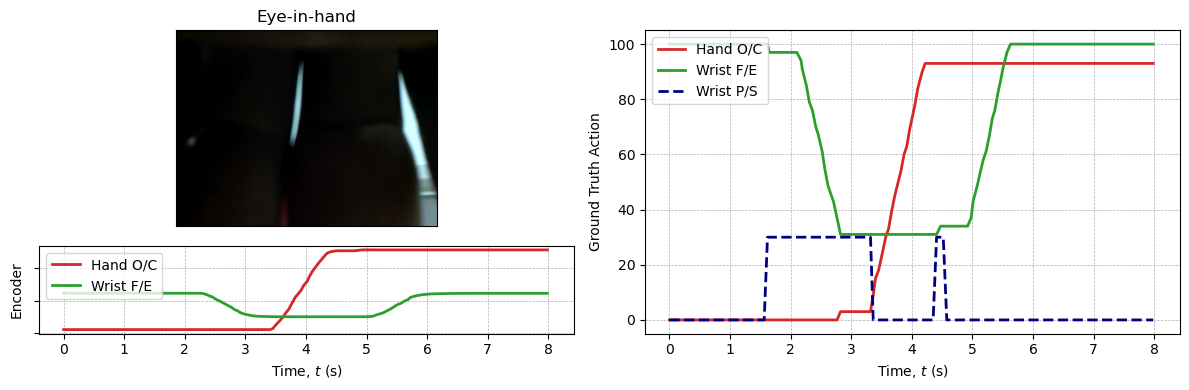

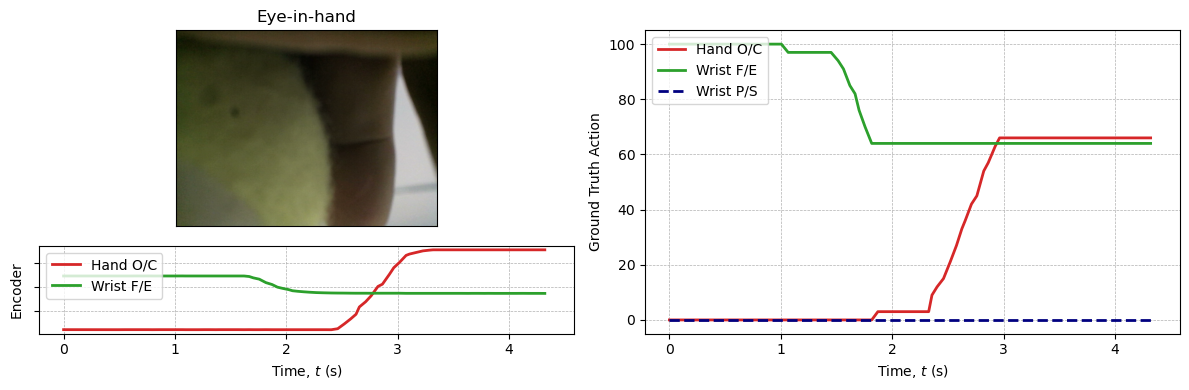

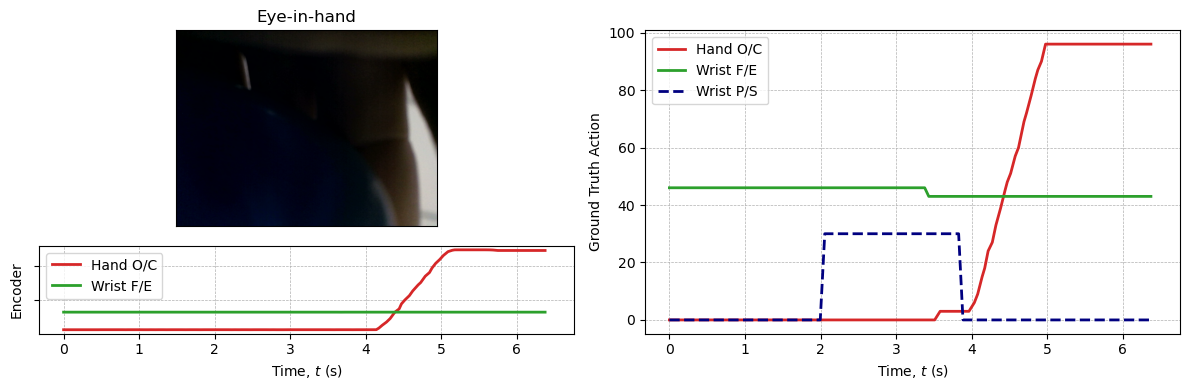

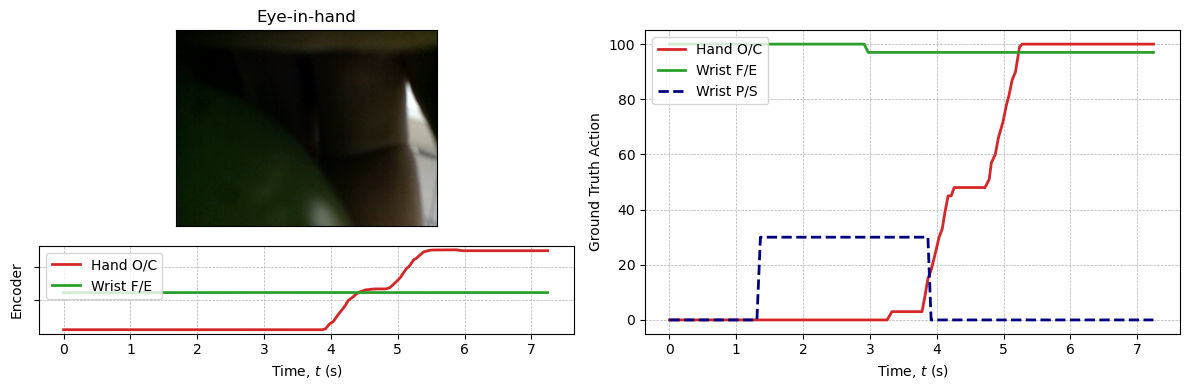

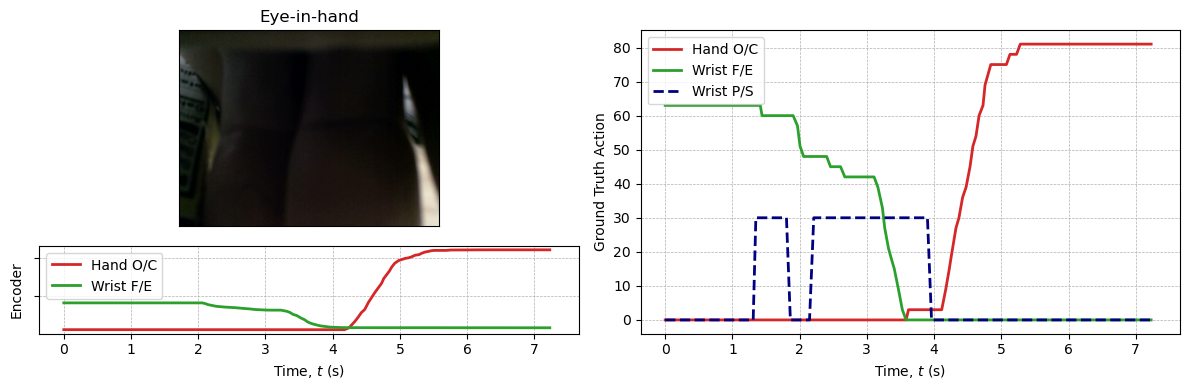

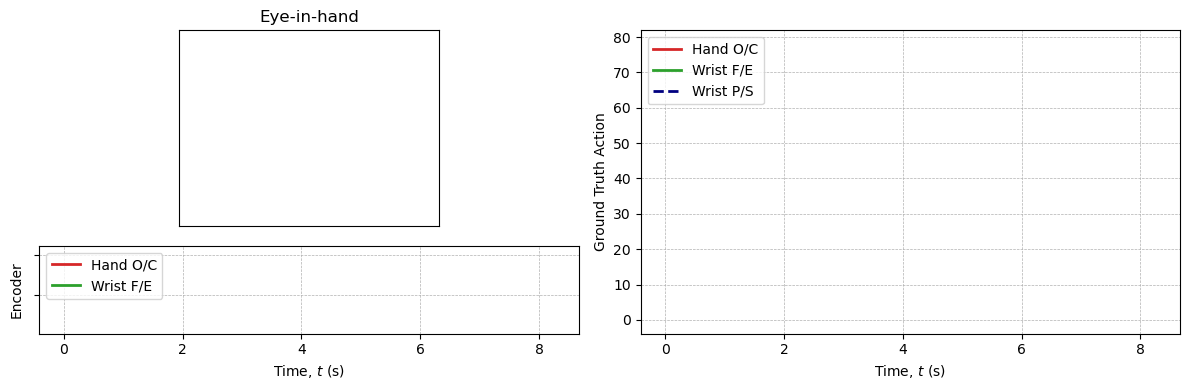

In [126]:
shelf_grasp_sampled_demo_paths = []

for object_name in df_shelf.object.unique():
    object_demo_paths = df_shelf[df_shelf.object == object_name]['demo_path'].to_list() # extract all demo paths for that scenario/object
    random_index = np.random.randint(len(object_demo_paths))
    shelf_grasp_sampled_demo_paths.append(object_demo_paths[random_index]) 

for i, demo_path in enumerate(shelf_grasp_sampled_demo_paths):
    store = zarr.open(demo_path)
    
    video_path = '/home/calessi-iit.local/Projects/hannes-imitation/figures/data_exploration/4_shelf_grasp/' + str(i+1) + '.mp4'

    make_video_demonstration_from_store(store, video_path)

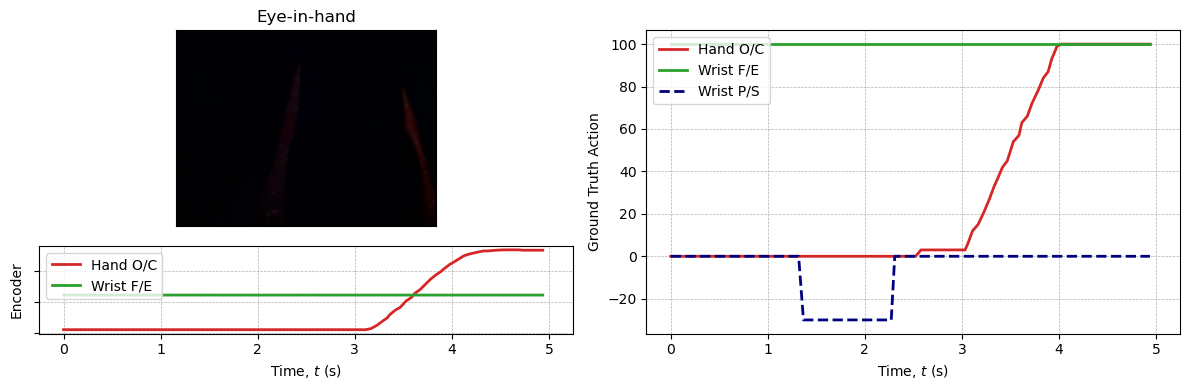

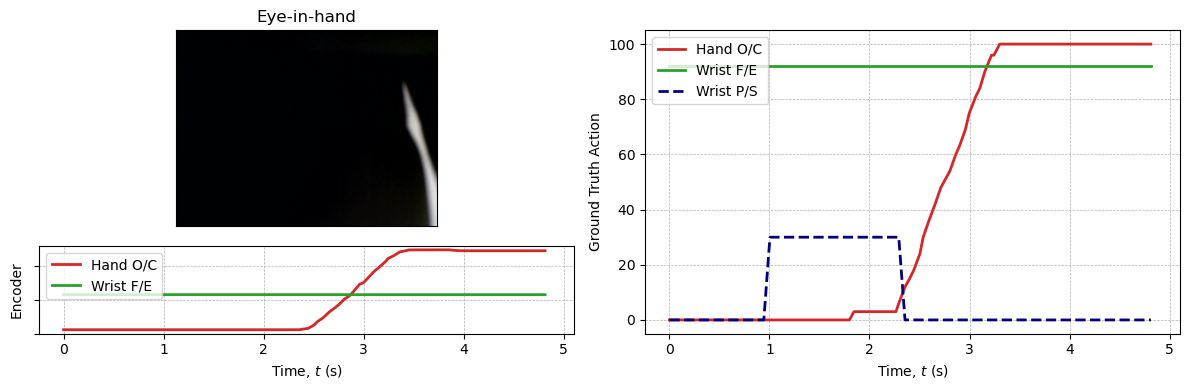

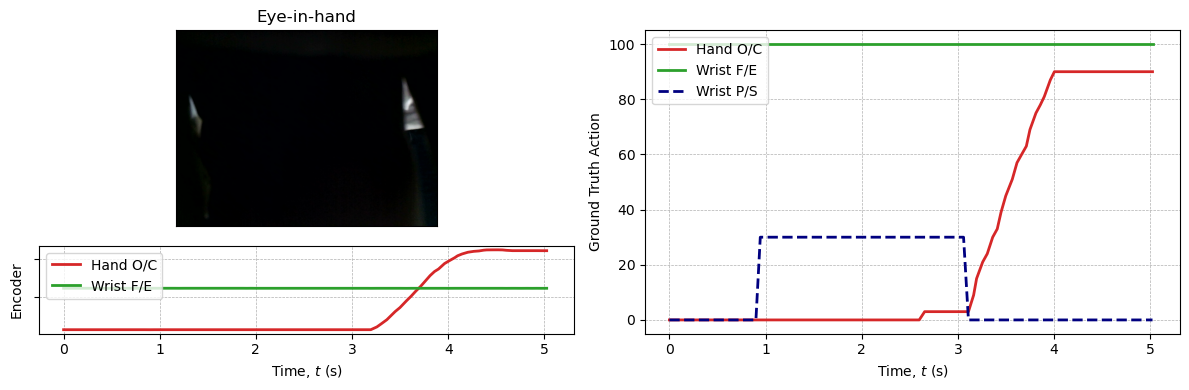

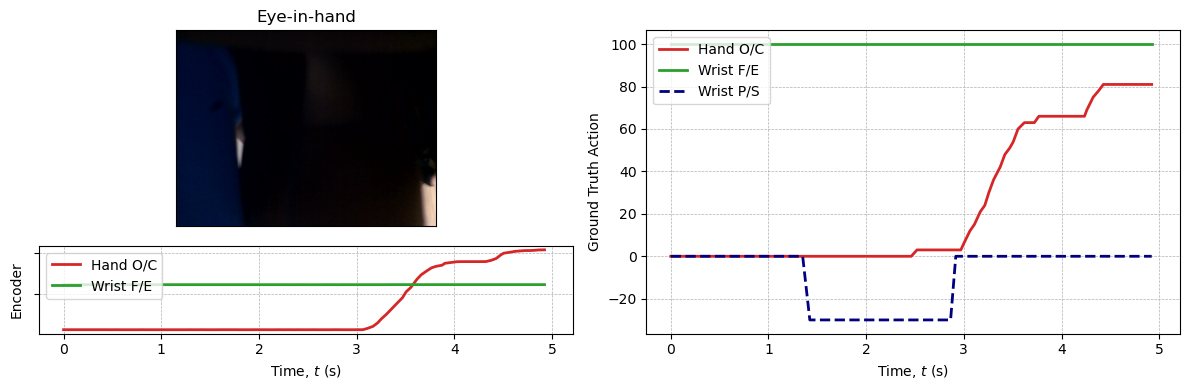

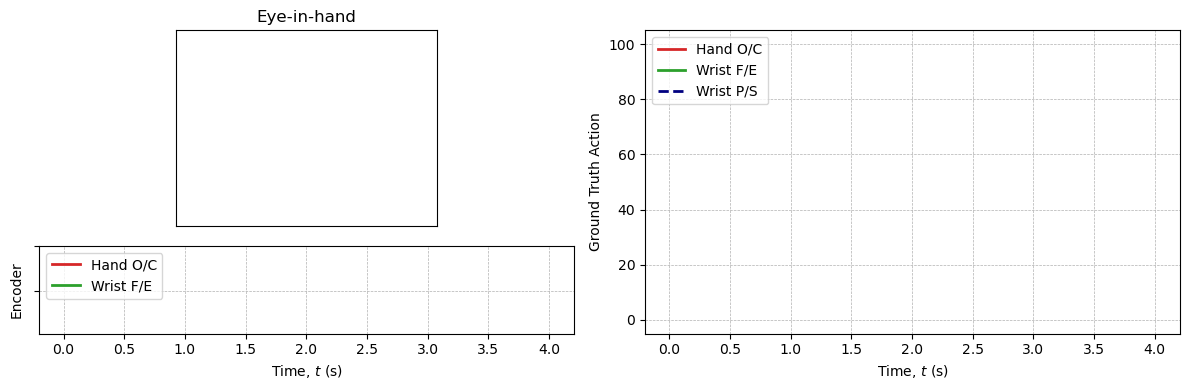

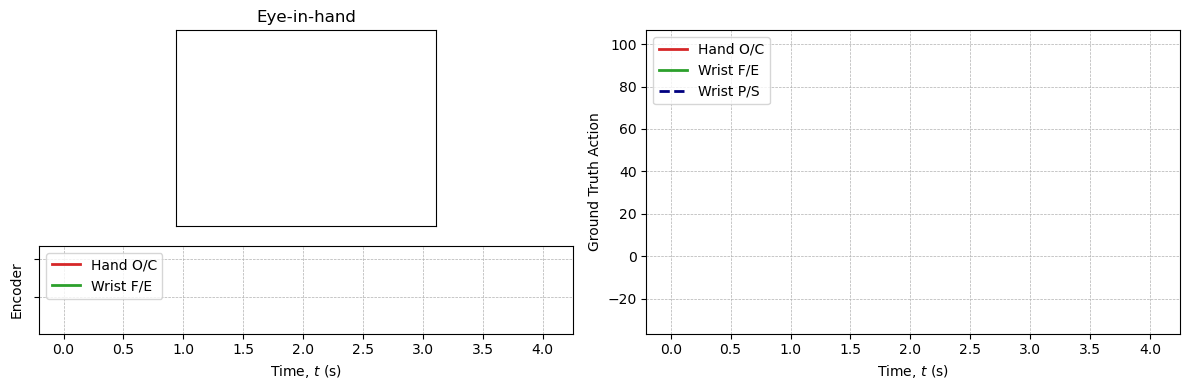

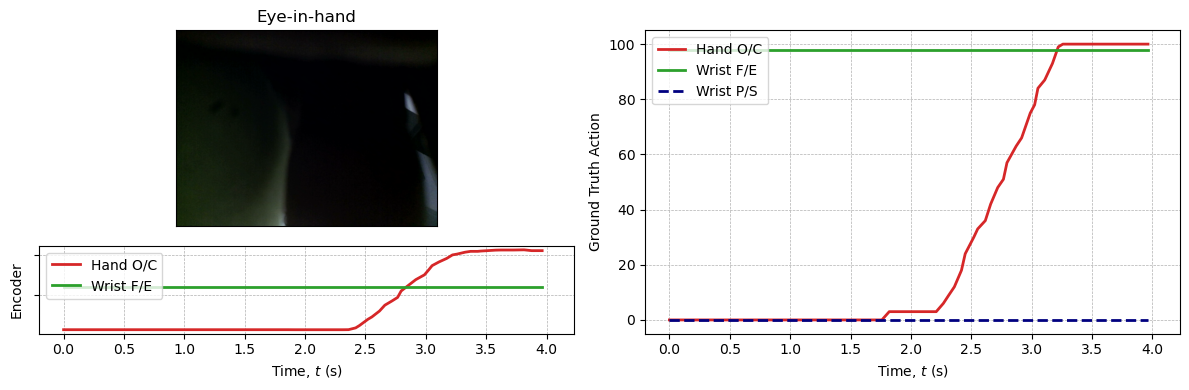

In [127]:
human_to_hannes_handover_sampled_demo_paths = []

for object_name in df_human_to_hannes.object.unique():
    object_demo_paths = df_human_to_hannes[df_human_to_hannes.object == object_name]['demo_path'].to_list() # extract all demo paths for that scenario/object
    random_index = np.random.randint(len(object_demo_paths))
    human_to_hannes_handover_sampled_demo_paths.append(object_demo_paths[random_index]) 

for i, demo_path in enumerate(human_to_hannes_handover_sampled_demo_paths):
    store = zarr.open(demo_path)
    
    video_path = '/home/calessi-iit.local/Projects/hannes-imitation/figures/data_exploration/7_human_to_hannes_handover/' + str(i+1) + '.mp4'

    make_video_demonstration_from_store(store, video_path)

In [124]:
def make_video_demonstration_from_store(store, video_path):
    # extract recorded quantities
    ref_move_hand = store['references']['hand'][:]
    ref_move_wrist_FE = store['references']['wrist_FE'][:]
    ref_move_wrist_PS = store['references']['wrist_PS'][:]
    mes_hand = store['joints']['hand']['position'][:]
    mes_wrist_FE = store['joints']['wrist_FE']['position'][:]
    camera = store['in-hand_camera_0']['rgb'][:]
    hand_times = store['time'][:]
    camera_times = store['in-hand_camera_0']['time'][:]

    # align data streams; get desired indeces for temporal alignment for hand time stamps and video time stamps
    # extract desired indeces for temporal alignment
    indeces_to_select = index_alignment(x_collection={'hand': hand_times, 'camera': camera_times})
    hand_times = hand_times[indeces_to_select['hand']]
    ref_move_hand = ref_move_hand[indeces_to_select['hand']]
    ref_move_wrist_FE = ref_move_wrist_FE[indeces_to_select['hand']]
    ref_move_wrist_PS = ref_move_wrist_PS[indeces_to_select['hand']]
    mes_hand = mes_hand[indeces_to_select['hand']]
    mes_wrist_FE = mes_wrist_FE[indeces_to_select['hand']]
    camera = camera[indeces_to_select['camera']]

    # preprocessing
    frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in camera] # from BGR to RGB
    frames = np.array([cv2.rotate(frame, cv2.ROTATE_180) for frame in frames]) # rotate eye-in-hand frames
    hand_times -= hand_times[0]
    video_fps = len(hand_times) / hand_times[-1] # compute video fps from data lengths

    # preallocate figure
    fig = plt.figure(figsize=(12, 4))

    rows_grid = 3
    cols_grid = 2
    gs = gridspec.GridSpec(nrows=rows_grid, ncols=cols_grid, width_ratios=[1, 1], height_ratios=[1, 1, 1])

    ax_frames = fig.add_subplot(gs[:2, :cols_grid-1])
    ax_encoder = fig.add_subplot(gs[2, :cols_grid-1])
    ax_action = fig.add_subplot(gs[:, -1])

    # eye-in-hand plot
    line_img = ax_frames.imshow(frames[0])
    ax_frames.set_xticks([])
    ax_frames.set_yticks([])
    ax_frames.set_title('Eye-in-hand')

    # action plot
    line_action_1 = ax_action.plot(hand_times, ref_move_hand, color='tab:red', linewidth=2, alpha=1, label="Hand O/C")[0]
    line_action_2 = ax_action.plot(hand_times, ref_move_wrist_FE, color='tab:green', linewidth=2, alpha=1, label='Wrist F/E')[0]
    line_action_3 = ax_action.plot(hand_times, ref_move_wrist_PS, color='navy', linewidth=2, alpha=1, linestyle='--', label='Wrist P/S')[0]
    ax_action.set_ylabel('Ground Truth Action')
    ax_action.grid(linewidth=0.5, linestyle='--')
    ax_action.set_xlabel("Time, $t$ (s)")
    ax_action.legend(loc='upper left', ncols=1)

    # encoder plot
    line_mes_1 = ax_encoder.plot(hand_times, mes_hand, color='tab:red', linewidth=2, alpha=1, label='Hand O/C')[0]
    line_mes_2 = ax_encoder.plot(hand_times, mes_wrist_FE, color='tab:green', linewidth=2, alpha=1, label='Wrist F/E')[0]
    ax_encoder.set_ylabel('Encoder')
    ax_encoder.grid(linewidth=0.5, linestyle='--')
    ax_encoder.set_xlabel("Time, $t$ (s)")
    ax_encoder.legend(loc='upper left', ncols=1)
    ax_encoder.set_yticklabels([])

    # Adjust layout for clarity
    plt.tight_layout()

        # Initialize function
    def init():
        line_img.set_data([[]])
        line_action_1.set_data([], [])
        line_action_2.set_data([], [])
        line_action_3.set_data([], [])
        line_mes_1.set_data([], [])
        line_mes_2.set_data([], [])

        return line_img, line_action_1, line_action_2, line_action_3, line_mes_1, line_mes_2

    # Update function
    def update(i):
        line_img.set_data(frames[i])

        line_action_1.set_data(hand_times[:i], ref_move_hand[:i])
        line_action_2.set_data(hand_times[:i], ref_move_wrist_FE[:i])
        line_action_3.set_data(hand_times[:i], ref_move_wrist_PS[:i])

        line_mes_1.set_data(hand_times[:i], mes_hand[:i])
        line_mes_2.set_data(hand_times[:i], mes_wrist_FE[:i])

        return line_img, line_action_1, line_action_2, line_action_3, line_mes_1, line_mes_2

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(frames), init_func=init, blit=False)
    ani.save(video_path, writer="ffmpeg", fps=video_fps, dpi=600)